# 1. Parameters, Imports, and Inputs

#### Declare Important Libraries, Parameters for Dataset, and Inputs of the user

In [1]:
import numpy as np
import matplotlib.pyplot as plt

histogram_bins = 1000
samples = 1000000                        #Samples to approximate ground truth (histogramming)
dataset_samples = 10000                  #Samples to test the network

In [2]:
mean = int(input("Please input the mean of the gaussian curve:"))
std_dev = int(input("Please input the stardard deviation of the gaussian curve:"))

Please input the mean of the gaussian curve:0
Please input the stardard deviation of the gaussian curve:1


# 2. Dataset and Histogramming
<ol>
    <li> Draw 1,000,00 samples and store it in raw_dataset variable 
    <li> Use histogram method to declare the bins and the number of count (use density)
    <li> Use digitize method for the ground truth to know the index
    <li> Use the first 10000 samples as the training and testing dataset
    <li> Plot for sanity check (10 bins vs 1000 bins)
</ol>

##### Take note that the actual samples used is only ten thousand not a million. The one million samples is interpreted to be the used only for histogramming and ground truth. Plus a million samples with 20 epochs is an relatively an overkill and would consume a lot of RAM. Though I did a variable called "dataset_samples" to adjust that. A million samples is actually possible, but I ran it on a 16GB RAM computer. Also, it takes around 2-3 minutes per epoch to finish so it's really time consuming to make "data_samples" varaible 1 million when 10,000 can do the job.

Test Dataset Size: (9000,)
Test Dataset Size: (1000,)


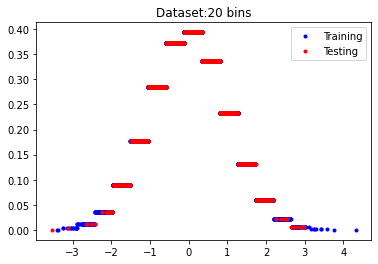

Test Dataset Size: (9000,)
Test Dataset Size: (1000,)


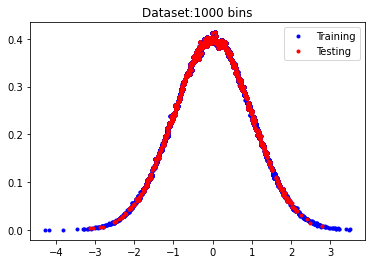

In [3]:
for i in [20,histogram_bins]:
    raw_dataset = np.random.normal(mean, std_dev,samples)
    count, bins = np.histogram(raw_dataset,bins=i,density=True)       #Takes the PDF (not PMF)
    index = np.digitize(raw_dataset,bins,right=True) - 1              #Gives the correct location of the sample - index
    ground_truth = count[index]                                       #Ground truth from 1 million samples and 1000 bins
 
    ''' Only take the first 1000 samples. Assume that np.random.normal satisfy this'''
    train_dataset = raw_dataset[:int(0.9*dataset_samples)]
    test_dataset = raw_dataset[int(0.9*dataset_samples):dataset_samples]
    train_truth = ground_truth[:int(0.9*dataset_samples)]
    test_truth = ground_truth[int(0.9*dataset_samples):dataset_samples]
    
    ''' Sanity Check'''
    print("Test Dataset Size: "+str(train_dataset.shape))
    print("Test Dataset Size: "+str(test_dataset.shape))
    plt.figure()
    plt.plot(train_dataset,train_truth,'b.',label="Training")
    plt.plot(test_dataset,test_truth,'r.',label="Testing")
    plt.title("Dataset:"+str(i)+' bins')
    plt.legend()
    plt.show()


<h1> 3. Build a 3 layer neural network </h1>
<ol>
    <li> Make a dictionary containing the network's architecture (Did not use sigmoid)
    <li> Make an initializer function with mean as 0 and standard deviation of 0.01 as the initial weights
    <li> Make the Feed Forward and the Backpropagation Activation Function
    <li> Make the Feed Forward Propagation
        <ul>
            <li> Do note that np.dot acts like a matrix multiplication for 2D numpy array
        </ul>
    <li> Make the Back Propagation
        <ul> 
            <li> Use MSE's derivative as the initial derivative
        </ul>
    <li> Make an "updater" to update the weights given the gradient values
    <li> Make a train function
    <li> Make a test fucntion
</ol>
        
Strong inspiration and source (with some minor edits and self-understanding): https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795

In [4]:
nn_architecture = [
    {"input_dim": 1, "output_dim": 64, "activation": "relu"},
    {"input_dim": 64, "output_dim": 64, "activation": "relu"},
    {"input_dim": 64, "output_dim": 64, "activation": "linear"},
    {"input_dim": 64, "output_dim": 1, "activation": "linear"},
]

def init_layers(nn_architecture, seed = 99):
    #np.random.seed(seed)
    number_of_layers = len(nn_architecture)   
    params= {}                                 #Declare a weight and parameter dictionary

    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        params['W' + str(layer_idx)] = np.random.normal(0,0.01,(layer_output_size, layer_input_size))
        params['b' + str(layer_idx)] = np.random.normal(0,0.01,(layer_output_size, 1))
        
    return params


''' Activation Function: Sigmoid not included since optional'''
def relu(Z):
    return np.maximum(0,Z)
    
def relu_backward(dA, Z):
    dZ = np.array(dA)
    dZ[Z <= 0] = 0;
    return dZ;

def linear(Z):
    return Z

def linear_backward(dA,Z):
    dZ = np.array(dA)
    return dZ;

'''Feed Forward Propagation'''
    
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    if activation == "relu":
        activation_func = relu
    elif activation == "linear":
        activation_func = linear
    else:
        raise Exception('Non-supported activation function')
        
    return activation_func(Z_curr), Z_curr

def full_forward_propagation(X, params_values, nn_architecture):
    memory = {}
    A_curr = X
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr
        
        activ_function_curr = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)]
        
        b_curr = params_values["b" + str(layer_idx)]
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    return A_curr, memory

''' Backward Propagation '''

def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    m = A_prev.shape[1]
    
    if activation == "relu":
        backward_activation_func = relu_backward
    elif activation == "linear":
        backward_activation_func = linear_backward
    else:
        raise Exception('Non-supported activation function')
    
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    
    dA_prev = 2*(Y_hat - Y)
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
        
    
    return grads_values

''' Get the COST/LOSS function using MSE'''

def get_cost_value(predictions,targets):
    # Retrieving number of samples in dataset
    samples_num = len(predictions)
    # Summing square differences between predicted and expected values
    accumulated_error = 0.0
    for prediction, target in zip(predictions, targets):
        accumulated_error += (prediction - target)**2
        
    # Calculating mean 
    mse_error = (1.0 / (samples_num)) * accumulated_error
    
    return mse_error

''' Update the parameters '''

def update(params_values, grads_values, nn_architecture, learning_rate):
    for layer_idx, layer in enumerate(nn_architecture):
        params_values["W" + str(layer_idx+1)] -= learning_rate * grads_values["dW" + str(layer_idx+1)]        
        params_values["b" + str(layer_idx+1)] -= learning_rate * grads_values["db" + str(layer_idx+1)]

    return params_values;

''' Train the network'''
def train(X, Y, nn_architecture, epochs, learning_rate):
    params_values = init_layers(nn_architecture, 1)
    cost_history = []
    
    for i in range(epochs):
        for j in range(X.shape[1]):
            Y_hat, cashe = full_forward_propagation(np.array([X[0][j]])[np.newaxis,:], params_values, nn_architecture)
            cost = get_cost_value(Y_hat, np.array([Y[0][j]])[np.newaxis,:])
            cost_history.append(cost)
        
            grads_values = full_backward_propagation(Y_hat, np.array([Y[0][j]])[np.newaxis,:], cashe, params_values, nn_architecture)
        
            params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        print("Epoch:"+str(i+1)+" Cost:"+str(np.mean(np.array(cost_history))))
        
    return params_values, cost_history

''' Test the network: Similar to Train except no updating of parameters and SGD'''
def test(X, Y, nn_architecture,params_values):
    cost_history = []
    Y_hat_history = np.zeros((Y.shape[1]))
    for j in range(X.shape[1]):
        Y_hat, cashe = full_forward_propagation(np.array([X[0][j]])[np.newaxis,:], params_values, nn_architecture)
        Y_hat_history[j] = Y_hat
        cost = get_cost_value(Y_hat, np.array([Y[0][j]])[np.newaxis,:])
        cost_history.append(cost)

    return np.mean(np.array(cost_history)),Y_hat_history



# Train the network
## Specification:
<ol> 
     <li> Batch size = 1 (Stochastic Gradient Descent instead of Batch Gradient Descent)
     <li> Learning Rate = 0.1
     <li> Epoch = 20
         
</ol>

### As seen from the cost, there seems to be a significant drop starting the 9th epoch.

### Note: 10,000 samples seems to be the right mix. 1,000,000 samples seems to be an overkill (taking too long to run per epoch).

In [5]:
params_values, cost_history = train(train_dataset[np.newaxis,:],train_truth[np.newaxis,:],nn_architecture,20,0.1)


Epoch:1 Cost:0.013757649675040786
Epoch:2 Cost:0.0137424075604257
Epoch:3 Cost:0.013737254736483313
Epoch:4 Cost:0.01373453892837391
Epoch:5 Cost:0.01373229104244983
Epoch:6 Cost:0.01298779222135676
Epoch:7 Cost:0.01114322296145903
Epoch:8 Cost:0.009757411617988114
Epoch:9 Cost:0.00867880909349026
Epoch:10 Cost:0.007815617855599475
Epoch:11 Cost:0.007109136269678957
Epoch:12 Cost:0.0065201562052288435
Epoch:13 Cost:0.006021638068462316
Epoch:14 Cost:0.005594264745651001
Epoch:15 Cost:0.005223830997576024
Epoch:16 Cost:0.00489967324748829
Epoch:17 Cost:0.0046136313154112
Epoch:18 Cost:0.004359355339187987
Epoch:19 Cost:0.004131831046006332
Epoch:20 Cost:0.003927047085428092


# Test the Network

<ol> 
    <li> Test the network (don't use gradient descent as seen from the function above
    <li> Plot for sanity check compared with the ground truth
</ol>

Test Dataset Cost: 4.253645162696881e-05
Test Dataset Size: (1000,)


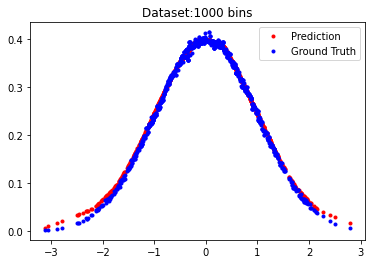

In [6]:
cost, Y_hat = test(test_dataset[np.newaxis,:],test_truth[np.newaxis,:],nn_architecture,params_values)

''' Sanity Check'''
print("Test Dataset Cost: "+str(cost))
print("Test Dataset Size: "+str(test_dataset.shape))
plt.figure()
plt.plot(test_dataset,Y_hat,'r.',label="Prediction")
plt.plot(test_dataset,test_truth,'b.',label="Ground Truth")
plt.title("Dataset:"+str(i)+' bins')

plt.legend()
plt.show()